In [794]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

In [795]:
os.chdir("C:/Users/admin/Desktop/Spring GRA/newdata")

In [796]:
df=pd.read_excel("Call Center Data Framework GSU Clean.xlsx",sheet_name='Master')

In [797]:
df.shape

(76, 68)

In [798]:
df.isnull().sum()

Forecast Month                                                                  0
Model Run Month                                                                 0
Contract Expiration Month 1                                                     0
Contract Expiration Month 2                                                     0
Enrollments (Call Volume)                                                       3
                                                                               ..
Expected Enrollment Rate (EER) - Fixed Roll-Off (1 Month Carryover)             0
Expected Enrollment Rate (EER) - Existing Customer Email (1 Month New)          0
Expected Enrollment Rate (EER) - Existing Customer Email (1 Month Carryover)    0
Expected Enrollment Rate (EER) - Blend & Extend (1 Month New)                   0
Expected Enrollment Rate (EER) - Blend & Extend (1 Month Carryover)             0
Length: 68, dtype: int64

In [799]:
Threshold = np.mean(df['Enrollments (Call Volume)'])
Threshold

13700.630136986301

In [800]:
df['Target'] = np.where(df['Enrollments (Call Volume)']>Threshold,1,0)
df.head()

,Forecast Month,Model Run Month,Contract Expiration Month 1,Contract Expiration Month 2,Enrollments (Call Volume),Enrollments (Average Handling Time),Escalations (Call Volume),Escalations (Average Handling Time),Other (Call Volume),Other (Average Handling Time),...,Expected Enrollment Rate (EER) - Saveback (1 Month Carryover),Expected Enrollment Rate (EER) - Convert & Extend (1 Month New),Expected Enrollment Rate (EER) - Convert & Extend (1 Month Carryover),Expected Enrollment Rate (EER) - Fixed Roll-Off (1 Month New),Expected Enrollment Rate (EER) - Fixed Roll-Off (1 Month Carryover),Expected Enrollment Rate (EER) - Existing Customer Email (1 Month New),Expected Enrollment Rate (EER) - Existing Customer Email (1 Month Carryover),Expected Enrollment Rate (EER) - Blend & Extend (1 Month New),Expected Enrollment Rate (EER) - Blend & Extend (1 Month Carryover),Target
0,2017-01-01,2016-11-01,2017-02-01,2017-03-01,9131.0,599.0,456.0,622.0,84566.0,435.0,...,0.0,0.01,0.00,0.1,0.0,0.03,0.00,0.0,0.0,0
1,2017-02-01,2016-12-01,2017-03-01,2017-04-01,8639.0,615.0,528.0,589.0,78274.0,422.0,...,0.0,0.01,0.01,0.1,0.1,0.03,0.03,0.0,0.0,0
2,2017-03-01,2017-01-01,2017-04-01,2017-05-01,9374.0,615.0,612.0,577.0,84834.0,416.0,...,0.0,0.01,0.01,0.1,0.1,0.03,0.03,0.0,0.0,0
3,2017-04-01,2017-02-01,2017-05-01,2017-06-01,6005.0,634.0,427.0,551.0,68185.0,423.0,...,0.0,0.01,0.01,0.1,0.1,0.03,0.03,0.0,0.0,0
4,2017-05-01,2017-03-01,2017-06-01,2017-07-01,7245.0,626.0,439.0,599.0,72970.0,415.0,...,0.0,0.01,0.01,0.1,0.1,0.03,0.03,0.0,0.0,0


In [801]:
df.drop(columns = ['Enrollments (Call Volume)','Enrollments (Average Handling Time)','Escalations (Call Volume)','Escalations (Average Handling Time)',
                  'Other (Call Volume)','Other (Average Handling Time)','Spanish (Call Volume)','Spanish (Average Handling Time)','Expected Enrollment Rate (EER) - Blend & Extend (1 Month New)','Expected Enrollment Rate (EER) - Blend & Extend (1 Month Carryover)'],inplace = True)
df.dropna(inplace = True)
df.shape

(73, 59)

In [802]:
df['Forecast_year'] = pd.to_datetime(df['Forecast Month']).dt.year
df['Forecast_month'] = pd.to_datetime(df['Forecast Month']).dt.month
df['Contract Expiration Month 1_year'] = pd.to_datetime(df['Contract Expiration Month 1']).dt.year
df['Contract Expiration Month 1_month'] = pd.to_datetime(df['Contract Expiration Month 1']).dt.month
df['Contract Expiration Month 2_year'] = pd.to_datetime(df['Contract Expiration Month 2']).dt.year
df['Contract Expiration Month 2_month'] = pd.to_datetime(df['Contract Expiration Month 2']).dt.month

In [803]:
cyclic_features = ['Forecast_year','Forecast_month','Contract Expiration Month 1_year','Contract Expiration Month 1_month',
                   'Contract Expiration Month 2_year','Contract Expiration Month 2_month']
for col in cyclic_features:
    max_value = df[col].max()
    df[col+'_sin'] = np.sin(df[col] * (2 * np.pi / max_value))
    df[col+'_cos'] = np.cos(df[col] * (2 * np.pi / max_value))

In [804]:
df.drop(columns = ['Contract Expiration Month 1','Contract Expiration Month 2','NYMEX Settlement Date','Forecast Month','Model Run Month'],inplace = True)
df.shape

(73, 72)

In [805]:
# Split the data into features and target
X = df.copy()
X.drop(['Target'],axis = 1,inplace = True)
y = df['Target']

In [806]:
X.shape

(73, 71)

In [807]:
tss = TimeSeriesSplit(n_splits = 4,test_size=15)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(58, 71) (15, 71) (58,) (15,)


Accuracy: 0.7333333333333333


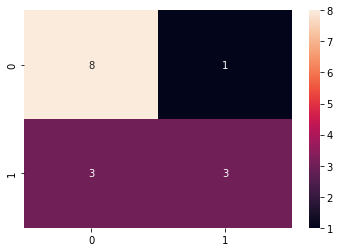

In [808]:
lr = LogisticRegression(solver='liblinear',penalty='l2',random_state=0)
lr.fit(X_train, y_train)
# Predict the test data
y_pred = lr.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)



# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [809]:
print(y_pred)

[1 0 1 1 0 0 0 0 0 0 0 1 0 0 0]


In [810]:
## Standardization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
scaled_data=scaler.transform(X)

In [811]:
##  Applying PCA Algorithms
from sklearn.decomposition import PCA

In [812]:
pca=PCA(0.95)

In [813]:
data_pca=pca.fit_transform(scaled_data)

In [814]:
pca.explained_variance_ratio_
pca.n_components_

19

In [815]:
data_pca=pd.DataFrame(data_pca)
data_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-6.550017,3.594754,-0.552372,-3.677215,-0.207550,2.865464,6.933186,3.562052,-0.203644,1.416909,0.029064,0.023473,1.171257,1.901073,-1.294911,-1.421406,2.404549,-0.732899,0.010212
1,-6.298609,3.197927,-1.286735,-2.067683,-1.630875,-1.209238,1.396535,-0.663300,0.502080,-0.186098,-1.501600,-0.487686,-0.675057,-0.291229,-0.705473,-0.508921,-0.814520,-0.805889,0.924186
2,-6.141108,2.115446,-2.082964,-2.887818,-1.965207,-0.876642,0.490588,-1.299068,-0.383924,-0.656187,-1.412817,0.060250,-0.237671,-0.111754,0.213175,-0.336970,-0.977918,-0.990936,0.612422
3,-6.553080,-0.119080,-2.285568,-3.116231,-1.580011,-0.495003,0.339689,-1.116772,-0.728035,-1.634044,-0.247652,0.531329,0.626253,-0.365855,0.281608,-0.001811,-0.092249,-0.137583,0.499616
4,-6.987731,-1.395707,-1.691994,-2.759889,-1.609407,-0.457991,0.476115,-1.042347,-0.461767,-1.878109,0.188883,0.899418,0.118420,-0.024766,0.210405,0.355135,0.347846,-0.353897,0.120726


In [816]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(data_pca,y,train_size=0.8,test_size=0.2,random_state=0)
print(X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape)

(58, 19) (15, 19) (58,) (15,)


In [817]:
model = LogisticRegression(solver='liblinear',penalty='l1',random_state=0)
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.7333333333333333

In [818]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the SVM model
model = svm.SVC()

# Define the parameter grid for GridSearchCV
param_grid = {'C': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Print the best score
print("Best score: ", grid_search.best_score_)


Best hyperparameters:  {'C': 0.001, 'gamma': 0.001}
Best score:  0.6028571428571429


In [819]:
from sklearn.svm import SVC
# Create an SVM object
svm = SVC(kernel='poly', C=0.001,gamma=0.001)

# Train the SVM model
svm.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.6
